In [87]:
import os
from flask import Flask, request, jsonify
from typing import Annotated, Literal , List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field , field_validator, ValidationInfo
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.graph.message import AnyMessage
from booking_agent.api.booking import BookingAPI
from booking_agent.api.geoCoding import GeoCodingAPI
from booking_agent.api.getKey import OAuthClient
from booking_agent.api.getQuotes import QuotesAPI
from booking_agent.api.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END

from quotes import Quote

llm = ChatOpenAI(temperature=0.2, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride. Do not autofill if not provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user. Do not autofill if not provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name. Do not autofill if not provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name. Do not autofill if not provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time. Do not autofill if not provided"
    )
    
    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_pickup = geoCodingAPI.get_geocoding(value)
            if geoCoding_pickup["status"] == "OK" :
                return geoCoding_pickup['results'][0]['formatted_address']
            else:
                raise ValueError(f"Invalid pick-up location: {value}")
    @field_validator('destination_location')
    @classmethod
    def validate_destination(cls, value : str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        
        # print (geoCoding_destination['results'][0]['formatted_address'])
        if value == '':
            return ''
        else :
            geoCoding_destination = geoCodingAPI.get_geocoding(value)
            if geoCoding_destination["status"] == "OK":
                if geoCoding_destination['results'][0]['formatted_address'] == info.data['pick_up_location']:
                    raise ValueError(f"Invalid destination location: {value}")
                else:
                    return geoCoding_destination['results'][0]['formatted_address']
            else:
            
                raise ValueError(f"Invalid destination location: {value}")

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    quote_id: str
    booking_info: BookingCarDetails 
    slot_empty: list
    change_request : str
def check_what_is_empty(user_personal_details):
    ask_for = []
    for field, value in user_personal_details.model_dump().items():
        if value in [None, "", 0]:  
            ask_for.append(field)
    return ask_for


def add_non_empty_details(current_details: BookingCarDetails, new_details: BookingCarDetails):
    non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=non_empty_details)
    return updated_details
def update_details(current_details: BookingCarDetails, new_details: BookingCarDetails , field : str):
    # non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=field)
    return updated_details

def ask_for_info(ask_list: list):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        ### ask_for list: {ask_for}"""
    )

    info_gathering_chain = first_prompt | llm | StrOutputParser()
    ai_chat = info_gathering_chain.invoke({"ask_for": ask_list})
    return ai_chat
def filter_response(text_input, user_details : BookingCarDetails ):
    chain = llm.with_structured_output(BookingCarDetails)
    res = chain.invoke(text_input)
    # add filtered info to the
    user_details = add_non_empty_details(user_details,res)
    ask_for = check_what_is_empty(user_details)
    return user_details, ask_for
def ask_confirm_info(booking_details: BookingCarDetails):
    # booking_details.
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
# def call_model (state):
#     messages = state["messages"]
#     response = llm.invoke(messages)
#     # We return a list, because this will get added to the existing list
#     return {"messages": [response]}
@tool
def get_booking_details(state : MessagesState):
    """ Call function to get the details for a booking from user"""
    # state = State(booking_info=BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""))
    chain = llm.with_structured_output(BookingCarDetails)
    response = chain.invoke(state["messages"][-1].content)
    booking_details = BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time="")
    user_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(user_details)
    while ask_for:  
        ai_response = ask_for_info(ask_for)
        print(ai_response)
        # print(ai_response)
        text_input = interrupt(ai_response)
        print("hi" + text_input)
        user_details, ask_for = filter_response(text_input, user_details)
        return {"human_input": text_input}
    
    return user_details
# @tool
def get_quotes(state :State):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(state['booking_info'].pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(state['booking_info'].destination_location)
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-02-10T19:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    quotes = []
    for item in quotes_data:
        quote = Quote(
        quote_id=item['quoteId'],
        expires_at=item['expiresAt'],
        vehicle_type=item['vehicleType'],
        price_value=item['price']['value'],
        price_currency=item['price']['currency'] if 'currency' in item['price'] and item['price']['currency'] is not None else 'CAD',
        luggage=item['luggage'],
        passengers=item['passengers'],
        provider_name=item['provider']['name'],
        provider_phone=item['provider']['phone']
        )
        quotes.append(quote)

    for quote in quotes:
        print({
            "title": f"{quote.vehicle_type} - {quote.price_value} {quote.price_currency}",
            "payload": f"{quote.quote_id}"
        })
    # print(quotes[0])
    return Command(
        update={
            "messages": [
                {
                    "role": "ai",
                    "content": "chooese Quotes",
                }
            ]
        },
        # goto=active_agent,
    )
@tool
def change_info(fields : List[str], booking_details : BookingCarDetails):
    """Change the booking details field """
    for field in fields:
        ai_response = ask_for_info([field])
        print(ai_response)
        text_input = input()
        chain = llm.with_structured_output(BookingCarDetails)
        response =chain.invoke(text_input)
        user_details = add_non_empty_details(booking_details,response)
    return user_details 
# @tool

       
# tools = [get_booking_details, get_quotes , change_info , accept_booking]  

# memory = MemorySaver()
# system_prompt = """
#         You are a very powerful assistant. 
#         If user express the intention to book a ride please guide the user through a booking process. 
#         Start by calling the function get_booking_details from the user's last message
#         Once provided, ask user for confirmation. If they confirm, proceed to provide the price. 
#         If not, ask if they want to change any details. 
#         Allow them to modify specific fields they mention and repeat the confirmation process
#     """
# agent_executor = create_react_agent(llm, tools = tools, state_modifier=system_prompt , checkpointer= memory)
# inputs = {"messages": []}  
# config = {"configurable": {"thread_id": "1"}}

# # print(state["booking_info"])
# while True:
#     user_input = input("You: ")
#     # print(state["booking_info"])
#     inputs["messages"].append(("user", user_input))
#     for s in agent_executor.stream(inputs,config=config, stream_mode="values"):
#         message = s["messages"][-1]
#         if isinstance(message, tuple):
#             print(f"Assistant: {message[1]}")
#         else:
#             message.pretty_print()

# app = Flask(__name__)

# # @app.route('/booking', methods=['POST'])
# # def booking():
    
# #     user_input = request.json.get("user_input", "")
# #     user_id = request.json.get("user_id", "")
# #     # Prepare inputs for LangChain agent
# #     inputs = {"messages": [("user", user_input)]}
# #     config = {"configurable": {"thread_id": user_id}}
    
# #     for s in agent_executor.stream(inputs, config=config, stream_mode="values"):
# #         message = s["messages"][-1].content
# #     return jsonify({"assistant_response": message})

# # # Run the Flask app
# # if __name__ == "__main__":
# #     booking()

In [88]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful assistant for a car booking system. 
            Your job is to help users book a car. If you don't understand a customer's request, ask questions to clarify.
            Make sure your answers are short but informative.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [89]:
def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = llm.invoke(prompt)
    return {"messages": response}

In [90]:
def info_chain(state : State):
    if "booking_info" in state:
        booking_details = state["booking_info"]
    else:
        booking_details = BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time="")
    
    chain = llm.with_structured_output(BookingCarDetails)
    response = chain.invoke(state["messages"][-1].content)
    user_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(user_details)
    return Command(update={"slot_empty": ask_for , "booking_info": user_details})

In [91]:
def human_node(
    state: State, config
):
# -> Command[Literal["get_info"]] :
    """A node for collecting user input."""
    
    user_input = interrupt(value="Ready for user input.")
    # identify the last active agent
    # (the last active node before returning to human)
    # langgraph_triggers = config["metadata"]["langgraph_triggers"]
    # if len(langgraph_triggers) != 1:
    #     raise AssertionError("Expected exactly 1 trigger in human node")

    # active_agent = langgraph_triggers[0].split(":")[1]
    # print("Active agent")
    # print(active_agent)
    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto="get_info"
        # goto=active_agent,
    )

In [92]:
def ask_info_empty(
    state: State,
):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        ### ask_for list: {ask_for}"""
    )
    info_gathering_chain = first_prompt | llm | StrOutputParser()
    if state["slot_empty"] : 
        ai_chat = info_gathering_chain.invoke({"ask_for": state["slot_empty"]})
        return Command(update= {"messages": [
                    {
                        "role": "ai",
                        "content": ai_chat,
                }
            ]} , goto="human")
    else :
        return END


In [93]:
def get_state(state : State):
    slot_empty = state["slot_empty"]
    if slot_empty == [] :
        return "ask_confirm"
    else : 
        return "ask_info_empty"
    

In [94]:
def ask_user_confirm(state : State):
    """Ask the user again to confirm the booking details. """
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {state["booking_info"].pick_up_location}\n"
        f"- Destination: {state["booking_info"].destination_location}\n"
        f"- Pickup Time: {state["booking_info"].pick_up_time}\n"
        f"- Name: {state["booking_info"].name}\n"
        f"- Contact Number: {state["booking_info"].number_phone}\n"
    )
    return Command(update= {"messages": [
                    {
                        "role": "ai",
                        "content": message,
                }
            ]} )

In [95]:
class Router(TypedDict):
    route: Literal["booking", "other"]

In [96]:
class RouterState(MessagesState):
    route: Literal["booking", "other"]

In [97]:
from pydantic import BaseModel, Field

class ConfirmDetails(BaseModel):
    """
    Represents the user's confirmation intent and request details.
    """
    confirm: str = Field(
        ..., 
        description="User confirmation intent. 'True' if the user confirm booking, 'False' otherwise."
    )
    request: str = Field(
        ..., 
        description="""Return request related to name, pickup and destination location, pickup time, phone number ,flight code.
        Returns 'None' if there is no request.Returns 'Cancel' if there is cancel."""
    )
    # continue_booking: bool = Field(
    #     # default= 'True',
    #     description="True if the user wants to change info and continue booking, False if they want to cancel."
    # )
    


In [98]:
router_model = llm.with_structured_output(Router)


In [99]:
def router_node(state: State):
    system_message = "Classify the incoming query as either about booking or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}



In [100]:
def route_after_prediction(
    state: RouterState,
) -> Literal["booking_graph", "call_model"]:
    if state["route"] == "booking":
        return "booking_graph"
    else:
        return "call_model"

In [101]:
def get_confirm_state(state: State):
    user_confirm = state["messages"][-1].content
    print(user_confirm)
    chain_confirm = llm.with_structured_output(ConfirmDetails)
    response = chain_confirm.invoke(user_confirm)
    # print(response.confirm)
    if (response.confirm == "True") :
        return "get_quotes_booking"
    else :
        if(response.request == "None"):
            # updates = ["confirm_change" ]
            
            return "confirm_change"
            
        elif(response.request == "Cancel"):
            return "cancel_book"
        else:
            # updates = [Command(update={"change_request" : response.request}) , "perform_request"]
            return "perform_request"

            # print(response.request)
    
    # return Command(
    #     update={"messages": [
    #         {
    #             "role": "human",
    #             "content": user_confirm
    #         }
    #     ]},
    #     goto="get_quotes_booking"
    # )


In [102]:
chain_confirm = llm.with_structured_output(ConfirmDetails)

reponse = chain_confirm.invoke("no i want to change name to Khoa and phone number 0912345678")
print(reponse)

confirm='False' request='Change name to Khoa and phone number to 0912345678.'


In [103]:
def human_node_confirm(
    state: State, config
):
    user_confirm = interrupt(value="Please confirm details booking.")
    return Command(
        update={
            "messages": [{"role": "human","content": user_confirm}]
        }
        # goto=active_agent,
    )

In [104]:
def human_choose_quote(
    state: State, config
):
    """A node for collecting user confirm."""
    
    user_confirm = interrupt(value="Please choose quote.")
    # print(user_confirm.get("messages"))
    command = [Command(
        update={
            "messages": [{"role": "human","content": user_confirm,}]
        }
        # goto=active_agent,
    ),Command(update={"quote_id": user_confirm}) ]
    return command
    

In [105]:
def accept_booking(state :State ):
    """Call function to accept booking with quote_ID."""
    bookingAPI = BookingAPI(bookingsAPI)
    # quote_id = tracker.get_slot("quoteId")
    person_name = state["booking_info"].name
    number_contact = state["booking_info"].number_phone
    
    passenger_info = {
        "title": "Mr",
        "phone": number_contact,
        "firstName": person_name,
        "lastName": ""
    }
    print(state["quote_id"])
    response = bookingAPI.create_booking(
        quote_id=state["quote_id"],
        passenger_info=passenger_info
    )
    print(response)
    return response

In [106]:
# acceptGraph =  StateGraph(State)
# acceptGraph.add_node("ask_confirm", ask_confirm)
# acceptGraph.add_node("get_quotes_booking", get_quotes)
# acceptGraph.add_node("get_confirm", get_confirm_state)
# acceptGraph.add_node("human_confirm", human_node_confirm)

# acceptGraph.add_edge(START, "human_confirm")
# # acceptGraph.add_edge("ask_confirm", "human_confirm")
# # acceptGraph.add_edge("ask_confirm", "get_confirm")
# acceptGraph.add_edge("human_confirm", "get_confirm")
# acceptGraph.add_edge("get_confirm", "get_quotes_booking")
# acceptGraph.add_edge("get_quotes_booking",END)

# acceptGraph = acceptGraph.compile()

In [107]:
# builder = StateGraph(State)
# # builder.add_node("call_model", call_model)
# builder.add_node("get_info", info_chain)
# builder.add_node("ask_info_empty", ask_info_empty)
# builder.add_node("human", human_node)
# builder.add_node("ask_confirm", acceptGraph)

# builder.add_edge(START, "get_info")

# # builder.add_edge("call_model", "get_info")

# builder.add_conditional_edges("get_info", get_state ,["ask_confirm", "ask_info_empty",END])
# builder.add_edge("ask_info_empty", "human")

# # builder.add_edge("call_model", "info")
# checkpointer = MemorySaver()
# graph = builder.compile(checkpointer=checkpointer)
# # graph = builder.compile()


In [108]:
def cancel_booking (state : State):
    return Command(
        update={
            "messages": [
                {
                    "role": "ai",
                    "content": "Your booking has been canceled.",
                }
            ]
        }
    )

In [109]:
def confirm_change(state :State):
    return Command (
        update= {
            "messages": [
                {
                    "role": "ai",
                    "content": "Do you want change booking infomation?",
                }
            ]
        },
        goto="human_request"
    ) 
    

In [110]:
def get_change_state(state :State):
    # ["ask_request", "cancel_book","perform_request"]
    
    user_confirm = state["messages"][-1].content
    chain_confirm = llm.with_structured_output(ConfirmDetails)
    response = chain_confirm.invoke(user_confirm)
    print(response.confirm)
    if (response.confirm == "True"):
        print(response.confirm)
        if (response.request == "None"):
            return "ask_request"
        else :
            # updates = [Command(update={"change_request" : response.request}) , "perform_request"]
            return "perform_request"
    else :
        return "cancel_book"
        
    
    
    
    
    


In [111]:
def human_node_request(state :State, config):
    """A node for collecting user confirm."""
    user_confirm = interrupt(value="change details booking.")
    # print(type(user_confirm))
    return Command(
        update={
            "messages": [{"role": "human","content": user_confirm}]
        }
        # goto=active_agent,
    )

In [112]:
def ask_request(state :State):
    
    return Command(
        update={
            "messages": [
                {
                    "role": "ai",
                    "content": "What would you like to change?",
                }
            ]
        }
    )

In [113]:
def human_ans_change(state :State, config):
    """A node for collecting user confirm."""
    user_confirm = interrupt(value="Please answer.")
    chain_confirm = llm.with_structured_output(ConfirmDetails)
    response = chain_confirm.invoke(user_confirm)
    return Command(
        update={
            "change_request" : response.request,
            "messages": [
                {
                    "role": "human",
                    "content": user_confirm,
                }
            ]
        }
    )

In [114]:
def perform_request(state :State , config) -> Command[Literal["ask_confirm"]] :
    chain = llm.with_structured_output(BookingCarDetails)
    response =chain.invoke(state["messages"][-1].content)
    user_details = add_non_empty_details(state["booking_info"],response)
    
    return Command(
        update={
            "booking_info" : user_details
        },
        goto="ask_confirm",
    ) 

In [115]:
builder = StateGraph(State)
# builder.add_node("call_model", call_model)
builder.add_node("get_info", info_chain)
builder.add_node("ask_info_empty", ask_info_empty)
builder.add_node("human", human_node)
builder.add_node("human_confirm", human_node_confirm)
builder.add_node("ask_confirm", ask_user_confirm)

builder.add_node("cancel_book",cancel_booking)

builder.add_node("confirm_change", confirm_change)

builder.add_node("perform_request", perform_request)

builder.add_node("human_request", human_node_request)
builder.add_node("ask_request", ask_request)
builder.add_node("human_ans", human_ans_change)


builder.add_node("get_quotes_booking", get_quotes)
builder.add_node("human_choose_quote", human_choose_quote)
builder.add_node("accept_booking", accept_booking) 




builder.add_edge(START, "get_info")
# builder.add_edge("get_info", "ask_confirm")
builder.add_conditional_edges("get_info", get_state ,["ask_confirm", "ask_info_empty"])
builder.add_edge("ask_info_empty", "human")
builder.add_edge("ask_confirm", "human_confirm")
builder.add_conditional_edges("human_confirm", get_confirm_state,["get_quotes_booking","cancel_book", "confirm_change","perform_request"])

builder.add_edge("confirm_change", "human_request")
builder.add_conditional_edges("human_request", get_change_state,["ask_request", "cancel_book","perform_request"])
builder.add_edge("get_quotes_booking", "human_choose_quote")
builder.add_edge("human_choose_quote", "accept_booking")

builder.add_edge("ask_request","human_ans")
builder.add_edge("human_ans", "perform_request")
builder.add_edge("accept_booking", END)
# builder.add_edge("call_model", "info")
# checkpointer = MemorySaver()
# graph = builder.compile(checkpointer=checkpointer)
subgraph = builder.compile()

In [116]:
parent_graph = StateGraph(RouterState)
parent_graph.add_node(router_node)
parent_graph.add_node("call_model", call_model)
parent_graph.add_node("booking_graph", subgraph)
parent_graph.add_edge(START, "router_node")
parent_graph.add_conditional_edges("router_node", route_after_prediction)
# parent_graph.add_edge("call_model", END)
# parent_graph.add_edge("booking_graph", END)
memory = MemorySaver()
graph = parent_graph.compile(checkpointer=memory)

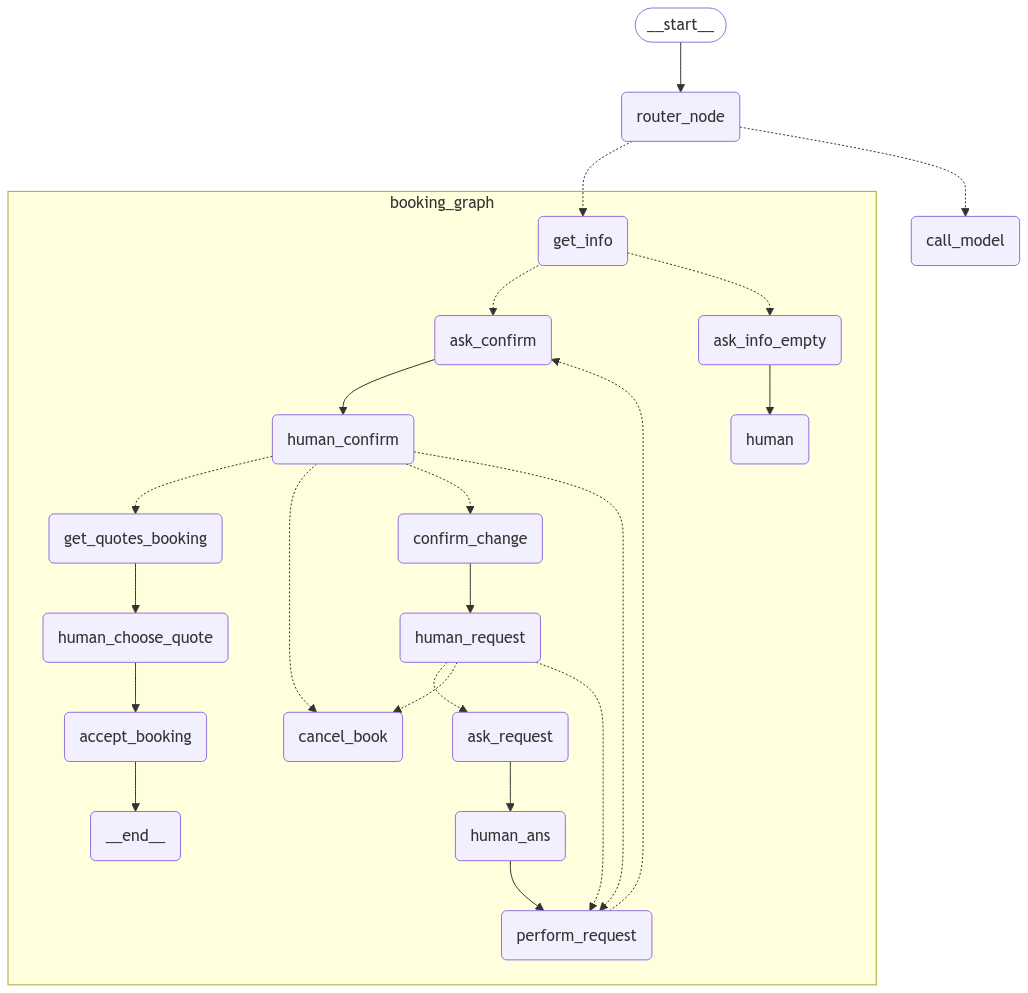

In [117]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=2).draw_mermaid_png()))

In [118]:
try

SyntaxError: expected ':' (3440435761.py, line 1)

In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    user = input("Bạn: ")
    if user.lower() == "q":
        print("Đã thoát chatbot.")
        break
    human_command = {"messages": user} 
    while True:  
        last_output = None  
        for output in graph.stream(human_command, config=config, stream_mode="updates", subgraphs=True):
            print(output)  
            last_output = output  
        if isinstance(last_output, tuple) and isinstance(last_output[1], dict) and "__interrupt__" in last_output[1]:
            user = input("Tiếp tục: ")  
            human_command = Command(resume=user)
        else:
            break 


((), {'router_node': {'route': 'other'}})
((), {'call_model': {'messages': AIMessage(content='Hello! How can I assist you with your car booking today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-c70030e6-f55e-4cfe-8859-bc89988fb6dc-0', usage_metadata={'input_tokens': 58, 'output_tokens': 14, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}})
((), {'call_model': {'messages': AIMessage(content='Hello! How can I assist you with your car booking today?', additional_kwargs={'refusal': N

In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
user = "hi"
human_command = Command(update ={"messages":"hi" })
for output in graph.stream(
        human_command, config=config, stream_mode="updates"
    ):  
        message = output
        print(message)

{'router_node': {'route': 'other'}}
{'call_model': {'messages': AIMessage(content='Hello! How can I assist you with your car booking today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 63, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5a006f52-c973-48cc-88df-436fc9274a44-0', usage_metadata={'input_tokens': 63, 'output_tokens': 14, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
user = "i want to book a car"
for output in graph.stream(
        {"messages": user}, config=config, stream_mode="updates", subgraphs=True
    ):  
        message = output
        print(message)

((), {'router_node': {'route': 'booking'}})
(('booking_graph:d6c66283-7541-612c-6c6d-00e7740fd21d',), {'get_info': {'slot_empty': ['name', 'number_phone', 'pick_up_location', 'destination_location', 'pick_up_time'], 'booking_info': BookingCarDetails(name='', number_phone='', pick_up_location='', destination_location='', pick_up_time='')}})
(('booking_graph:d6c66283-7541-612c-6c6d-00e7740fd21d',), {'ask_info_empty': {'messages': [{'role': 'ai', 'content': 'What is your name?'}]}})
((), {'__interrupt__': (Interrupt(value='Ready for user input.', resumable=True, ns=['booking_graph:d6c66283-7541-612c-6c6d-00e7740fd21d', 'human:dbe45b1c-2b17-4fb3-d90e-bd670f5cf63a'], when='during'),)})


In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
user = "hi"
for output in graph.stream(
        {"messages": user}, config=config, stream_mode="updates"
    ):  
        message = output
        print(message)

{'router_node': {'route': 'other'}}
{'call_model': {'messages': AIMessage(content='Hello! How can I assist you with your car booking today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-e016afad-8e4b-4eda-99e7-44bfcbc7deca-0', usage_metadata={'input_tokens': 58, 'output_tokens': 14, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [119]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
user = "i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and call me 0917181880 "
for output in graph.stream(
        {"messages": user}, config=config, stream_mode="updates", subgraphs=True
    ):  
        message = output
        print(message)
        # if isinstance(message, tuple):
        #     print(f"Assistant: {message[1]}")

((), {'router_node': {'route': 'booking'}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'get_info': {'slot_empty': [], 'booking_info': BookingCarDetails(name='Huy', number_phone='0917181880', pick_up_location='460 Đ. Trần Đại Nghĩa, Hoà Hải, Điện Bàn, Quảng Nam 550000, Vietnam', destination_location='271 Đ. Nguyễn Văn Linh, Vĩnh Trung, Hải Châu, Đà Nẵng 550000, Vietnam', pick_up_time='9 tomorrow')}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'ask_confirm': {'messages': [{'role': 'ai', 'content': 'Please confirm your ride details:\n- Pickup Location: 460 Đ. Trần Đại Nghĩa, Hoà Hải, Điện Bàn, Quảng Nam 550000, Vietnam\n- Destination: 271 Đ. Nguyễn Văn Linh, Vĩnh Trung, Hải Châu, Đà Nẵng 550000, Vietnam\n- Pickup Time: 9 tomorrow\n- Name: Huy\n- Contact Number: 0917181880\n'}]}})
((), {'__interrupt__': (Interrupt(value='Please confirm details booking.', resumable=True, ns=['booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211', 'human_confirm:70c156cc-8206-d1

In [120]:
human_command = Command(resume ="no " )
for output in graph.stream(
        human_command, config=config, stream_mode="updates", subgraphs=True
    ):  
        message = output
        print(message)

no 
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'human_confirm': {'messages': [{'role': 'human', 'content': 'no '}]}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'confirm_change': {'messages': [{'role': 'ai', 'content': 'Do you want change booking infomation?'}]}})
((), {'__interrupt__': (Interrupt(value='change details booking.', resumable=True, ns=['booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211', 'human_request:c20d1b59-188d-b0fb-d80f-4f517a1cf266'], when='during'),)})


In [121]:
human_command = Command(resume = "yes" )
for output in graph.stream(
        human_command, config=config, stream_mode="updates", subgraphs=True
    ):  
        message = output
        print(message)

True
True
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'human_request': {'messages': [{'role': 'human', 'content': 'yes'}]}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'ask_request': {'messages': [{'role': 'ai', 'content': 'What would you like to change?'}]}})
((), {'__interrupt__': (Interrupt(value='Please answer.', resumable=True, ns=['booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211', 'human_ans:8a651b79-9b26-20a5-2696-8b808db11501'], when='during'),)})


In [122]:
human_command = Command(resume = "change Name" )
for output in graph.stream(
        human_command, config=config, stream_mode="updates", subgraphs=True
    ):  
        message = output
        print(message)
        



(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'human_ans': {'change_request': 'Change Name', 'messages': [{'role': 'human', 'content': 'change Name'}]}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'perform_request': {'booking_info': BookingCarDetails(name='John Doe', number_phone='123-456-7890', pick_up_location='123 Main St, Springfield, MA 01105, USA', destination_location='456 Elm St, West Springfield, MA 01089, USA', pick_up_time='3:00 PM')}})
(('booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211',), {'ask_confirm': {'messages': [{'role': 'ai', 'content': 'Please confirm your ride details:\n- Pickup Location: 123 Main St, Springfield, MA 01105, USA\n- Destination: 456 Elm St, West Springfield, MA 01089, USA\n- Pickup Time: 3:00 PM\n- Name: John Doe\n- Contact Number: 123-456-7890\n'}]}})
((), {'__interrupt__': (Interrupt(value='Please confirm details booking.', resumable=True, ns=['booking_graph:e9d12e92-b7c0-1526-0c71-38e5fdb6a211', 'human_confirm:14c0

In [ ]:
human_command = Command(resume= "yes i want to change name to Khoa")
for output in graph.stream(
        human_command, config , stream_mode= "updates", subgraphs=True
    ):  
        message = output
        print(message)

4564
(('booking_graph:2ece3ed3-792c-01ad-3c35-85af13dc09cc',), {'human_request': {'messages': [{'role': 'human', 'content': 'yes i want to change name to Khoa'}]}})
(('booking_graph:2ece3ed3-792c-01ad-3c35-85af13dc09cc',), {'perform_request': {'booking_info': BookingCarDetails(name='Khoa', number_phone='0917181880', pick_up_location='460 Đ. Trần Đại Nghĩa, Hoà Hải, Điện Bàn, Quảng Nam 550000, Vietnam', destination_location='271 Đ. Nguyễn Văn Linh, Vĩnh Trung, Hải Châu, Đà Nẵng 550000, Vietnam', pick_up_time='9 tomorrow')}})
(('booking_graph:2ece3ed3-792c-01ad-3c35-85af13dc09cc',), {'ask_confirm': {'messages': [{'role': 'ai', 'content': 'Please confirm your ride details:\n- Pickup Location: 460 Đ. Trần Đại Nghĩa, Hoà Hải, Điện Bàn, Quảng Nam 550000, Vietnam\n- Destination: 271 Đ. Nguyễn Văn Linh, Vĩnh Trung, Hải Châu, Đà Nẵng 550000, Vietnam\n- Pickup Time: 9 tomorrow\n- Name: Khoa\n- Contact Number: 0917181880\n'}]}})
((), {'__interrupt__': (Interrupt(value='Please confirm details book

In [ ]:

human_command = Command(resume ="ok" )

events = graph.stream(human_command,config, stream_mode="updates", subgraphs=True)
for event in events:
        print(event)

AttributeError: 'str' object has no attribute 'messages'

In [ ]:

human_command = Command(resume="8d07c3f5-9086-429f-90a9-0f76b06f27f1")
for output in graph.stream(
        human_command, config , stream_mode= "updates", subgraphs=True
    ):  
        print(output)

8d07c3f5-9086-429f-90a9-0f76b06f27f1
(('booking_graph:cbe011ac-e6eb-376a-fdbd-649ec76c7681',), {'human_choose_quote': {'messages': [{'role': 'human', 'content': '8d07c3f5-9086-429f-90a9-0f76b06f27f1'}], 'quote_id': '8d07c3f5-9086-429f-90a9-0f76b06f27f1'}})
{'error': 400, 'status': '{"message":"The phone number is not valid according to the E.164 format.","code":"VALIDATION_ERROR","statusCode":400,"errorCode":"VALIDATION_ERROR","data":{"statusCode":400},"traceId":"76148f27-e1d0-438d-86ab-f16ba898322b"}'}
(('booking_graph:cbe011ac-e6eb-376a-fdbd-649ec76c7681',), {'accept_booking': None})
((), {'booking_graph': {'messages': [HumanMessage(content='i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy ', additional_kwargs={}, response_metadata={}, id='b9ad91d0-6a5f-4ee6-90eb-f86c8e831092'), AIMessage(content='What is your phone number?', additional_kwargs={}, response_metadata={}, id='09811c06-3df7-4c1d-87f3-4b269478a508'), Human

In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": user}, config=config, stream_mode="updates"
    ):  
        print(output)
        # last_message = next(iter(output.values()))["messages"][-1]
        # last_message.pretty_print()

User (q/Q to quit): q
AI: Byebye


In [ ]:
i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy call me 0917181880

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3553203731.py, line 1)

In [ ]:
# import uuid

# thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# inputs = [
#     # 1st round of conversation,
#     {
#         "messages": [
#             {"role": "user", "content": "I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now"}
#         ]
#     },
#     # Since we're using `interrupt`, we'll need to resume using the Command primitive.
#     # 2nd round of conversation,
#     Command(
#         resume="name Huy."
#     ),
#     # 3rd round of conversation,
#     Command(
#         resume="0917181880"
#     ),
# ]

# for idx, user_input in enumerate(inputs):
#     print()
#     print(f"--- Conversation Turn {idx + 1} ---")
#     print()
#     print(f"User: {user_input}")
#     print()
#     for update in graph.stream(
#         user_input,
#         config=thread_config,
#         stream_mode="updates",
#     ):
#         for node_id, value in update.items():
#             if isinstance(value, dict) and value.get("messages", []):
#                 last_message = value["messages"][-1]
#                 if isinstance(last_message, dict) or last_message.type != "ai":
#                     continue
#                 print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now'}]}

call_model: To book a car from 271 Nguyen Van Linh to 466 Nguyen Van Linh in Da Nang, you can use a ride-hailing app like Grab, Gojek, or a local taxi service. Here’s how you can do it:

1. **Open the App**: Launch your preferred ride-hailing app on your smartphone.
2. **Set Pickup Location**: Enter "271 Nguyen Van Linh" as your pickup location.
3. **Set Drop-off Location**: Enter "466 Nguyen Van Linh" as your destination.
4. **Choose Vehicle Type**: Select the type of vehicle you want (standard, premium, etc.).
5. **Confirm Booking**: Review the fare estimate and confirm your booking.
6. **Wait for Driver**: Once booked, wait for the driver to arrive at your location.

If you prefer to call a local taxi service, you can find their contact number online or through a local directory. Make sure to provide them with the pic

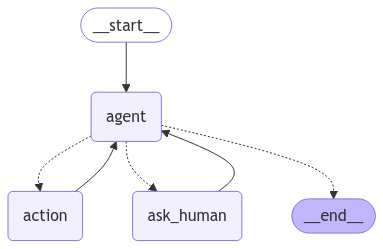